In [27]:
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.nn import functional as F
from torchvision import transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR

import torchvision

from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import copy

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
DATASET_PATH = Path('D:/Dev/Datasets/FoodClassification')
PREPROC_PATH = Path('D:/Dev/Datasets/PreprocFoodClassification')
PREPROC_PATH.mkdir(parents=True, exist_ok=True)

In [4]:
# Transformations for the images
transforms = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

originalDataset = datasets.ImageFolder(root=DATASET_PATH)

In [84]:
# Preprocess the dataset and save it to disk to save time loading from disk
for idx, (img, label) in enumerate(tqdm(originalDataset, desc="Preprocessing images")):
    imgTensor = transforms(img)
    
    # Get the class folder path in preprocessed directory
    className = originalDataset.classes[label]
    classFolder = PREPROC_PATH / className
    classFolder.mkdir(parents=True, exist_ok=True)
    
    # Save tensor as a .pt file
    tensor_path = classFolder / f"{idx}.pt"
    torch.save((imgTensor, label), tensor_path)

Preprocessing images:  59%|█████▉    | 3739/6340 [01:16<00:46, 55.92it/s] C:\Users\Peblo\AppData\Roaming\Python\Python310\site-packages\PIL\Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Preprocessing images: 100%|██████████| 6340/6340 [02:04<00:00, 50.90it/s] 


In [5]:
CLASSES = originalDataset.classes
NUM_CLASES = len(CLASSES)

print(NUM_CLASES, CLASSES)

15 ['apple_pie', 'baked_potato', 'burger', 'cheesecake', 'crispy_chicken', 'donut', 'fried_rice', 'fries', 'hot_dog', 'ice_cream', 'omelette', 'pizza', 'sandwich', 'sushi', 'taco']


In [6]:
# Custom datasert to load the preprocessed data
class FoodDataset(Dataset):
    def __init__(self, root):
        self.root = Path(root)
        self.files = list(self.root.glob("**/*.pt"))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_tensor, label = torch.load(self.files[idx], weights_only=True)
        return img_tensor, label

dataset = FoodDataset(PREPROC_PATH)

In [7]:
# Perform the split into training and validation
trainSize = int(0.8 * len(dataset))
valSize = len(dataset) - trainSize
trainDataset, valDataset = random_split(dataset, [trainSize, valSize])

In [8]:
# Create the loaders
trainLoader = DataLoader(trainDataset, batch_size=32, shuffle=True, pin_memory=True)
valLoader = DataLoader(valDataset, batch_size=32, shuffle=False, pin_memory=True)

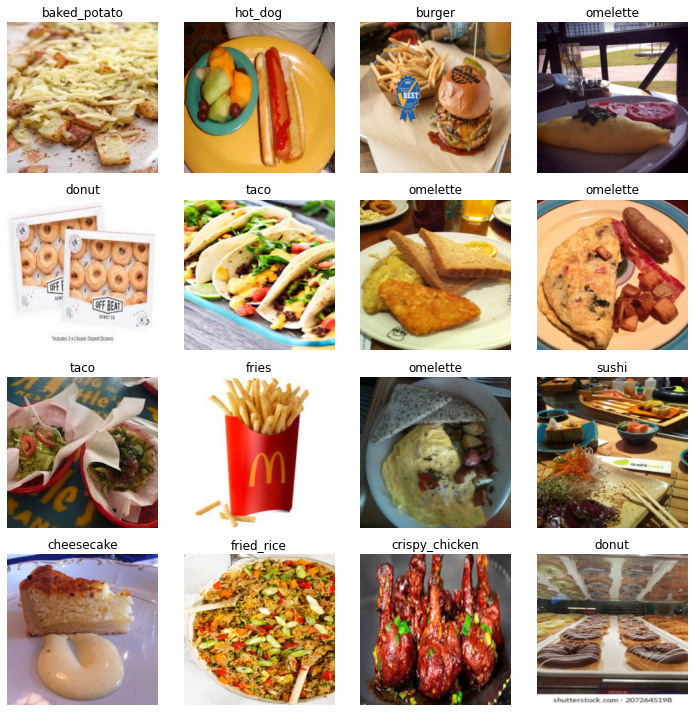

In [19]:
# Plot some of the images and their classes
images, labels = next(iter(trainLoader))
images = images.cpu().numpy()
labels = labels.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10)) 
axes = axes.flatten()

for ax, img, label in zip(axes, images, labels):
    img = (img.transpose(1, 2, 0) + 1) / 2
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(CLASSES[label])

plt.tight_layout()
plt.show()

In [15]:
class Bottleneck(nn.Module):
    def __init__(self, inChan, outChan, expansion=4, stride=1):
        super().__init__()

        midChan = outChan // expansion

        self.convBlock = nn.Sequential(
            nn.Conv2d(inChan, midChan, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(midChan),
            nn.ReLU(inplace=True),

            nn.Conv2d(midChan, midChan, kernel_size=3, stride=stride, padding=1, bias=False),
            nn.BatchNorm2d(midChan),
            nn.ReLU(inplace=True),

            nn.Conv2d(midChan, outChan, kernel_size=1, stride=1, bias=False),
            nn.BatchNorm2d(outChan),
        )

        self.downsample = None

        if inChan != outChan or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(inChan, outChan, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outChan)
            ) 

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        out = self.convBlock(x)

        skip = x
        if self.downsample:
            skip = self.downsample(x)

        out += skip
        out = self.relu(out)

        return out


In [56]:
# Kinda Resnet50
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, stride=2),

    # Stage 1
    Bottleneck(64, 256, stride=1),
    Bottleneck(256, 256, stride=1),
    Bottleneck(256, 256, stride=1),

    # Stage 2
    Bottleneck(256, 512, stride=2),
    Bottleneck(512, 512, stride=1),
    Bottleneck(512, 512, stride=1),
    Bottleneck(512, 512, stride=1),

    # Stage 3
    Bottleneck(512, 1024, stride=2),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),
    Bottleneck(1024, 1024, stride=1),

    # Stage 4
    Bottleneck(1024, 2048, stride=2),
    Bottleneck(2048, 2048, stride=1),
    Bottleneck(2048, 2048, stride=1),

    nn.AdaptiveAvgPool2d(output_size=(1, 1)),
    nn.Flatten(),
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, NUM_CLASES),
    nn.Sigmoid(),
)

In [57]:
model.to(device)
print(model)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Bottleneck(
    (convBlock): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (downsample): Sequential(
      (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(

In [58]:
lossFunc = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

trainLosses = []
trainAcc = []
valLosses = []
valAcc = []

bestLoss = float('inf')
bestModelWeights = None
patience = 10

def getBatchAccuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / len(y)

def validate():
    valLoss = 0
    correct = 0
    model.eval()

    with torch.no_grad():
        for x, y in valLoader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            valLoss += lossFunc(output, y).item() * x.size(0)
            correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = valLoss / valSize
    accuracy = correct / valSize

    valLosses.append(avgLoss)
    valAcc.append(accuracy)

    print(f'(val) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

    global bestLoss, bestModelWeights, patience

    if valLoss < bestLoss:
        bestLoss = valLoss
        bestModelWeights = copy.deepcopy(model.state_dict())
        patience = 10

    else:
        patience -= 1
        if patience == 0:
            return True
        
    return False

def train():
    trainLoss = 0
    correct = 0
    model.train()
    
    for x, y in trainLoader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batchLoss = lossFunc(output, y)
        batchLoss.backward()
        optimizer.step()

        trainLoss += batchLoss.item() * x.size(0)
        correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = trainLoss / trainSize
    accuracy = correct / trainSize

    trainLosses.append(avgLoss)
    trainAcc.append(accuracy)

    print(f'(train) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

In [59]:
epochs = 100

# Train the model
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    train()
    if validate(): 
        break # Early stopping
    
    scheduler.step()

Epoch 0
(train) Loss: 2.5759 Accuracy: 0.1362
(val) Loss: 2.6096 Accuracy: 0.1341
Epoch 1
(train) Loss: 2.4984 Accuracy: 0.1571
(val) Loss: 2.6122 Accuracy: 0.1459
Epoch 2
(train) Loss: 2.4814 Accuracy: 0.1593
(val) Loss: 2.4491 Accuracy: 0.1711
Epoch 3
(train) Loss: 2.4713 Accuracy: 0.1631
(val) Loss: 2.5493 Accuracy: 0.1238
Epoch 4
(train) Loss: 2.4659 Accuracy: 0.1668
(val) Loss: 2.4642 Accuracy: 0.1609
Epoch 5
(train) Loss: 2.4626 Accuracy: 0.1587
(val) Loss: 2.5055 Accuracy: 0.1388
Epoch 6
(train) Loss: 2.4528 Accuracy: 0.1593
(val) Loss: 2.4365 Accuracy: 0.1688
Epoch 7
(train) Loss: 2.4349 Accuracy: 0.1729
(val) Loss: 2.4324 Accuracy: 0.1648
Epoch 8
(train) Loss: 2.4371 Accuracy: 0.1822
(val) Loss: 2.4666 Accuracy: 0.1664
Epoch 9
(train) Loss: 2.4379 Accuracy: 0.1798
(val) Loss: 2.4409 Accuracy: 0.1593
Epoch 10
(train) Loss: 2.4184 Accuracy: 0.1899
(val) Loss: 2.4051 Accuracy: 0.1743
Epoch 11
(train) Loss: 2.4116 Accuracy: 0.1997
(val) Loss: 2.4041 Accuracy: 0.1688
Epoch 12
(trai

In [60]:
model.load_state_dict(bestModelWeights)

<All keys matched successfully>

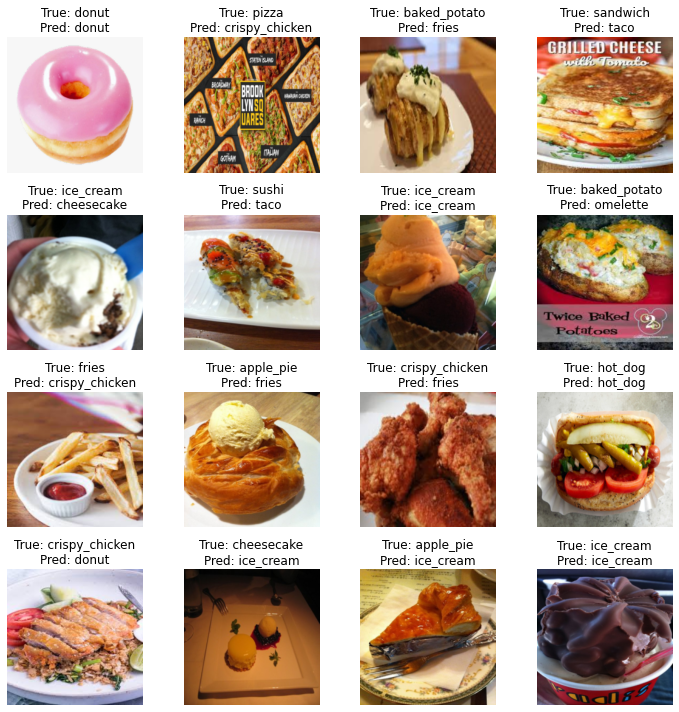

In [61]:
# Print the model predictions
model.eval()
images, labels = next(iter(valLoader))

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for ax, img, label, pred in zip(axes, images, labels, preds):
    img = (img.transpose(1, 2, 0) + 1) / 2
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'True: {CLASSES[label]}\nPred: {CLASSES[pred]}')

plt.tight_layout()
plt.show()

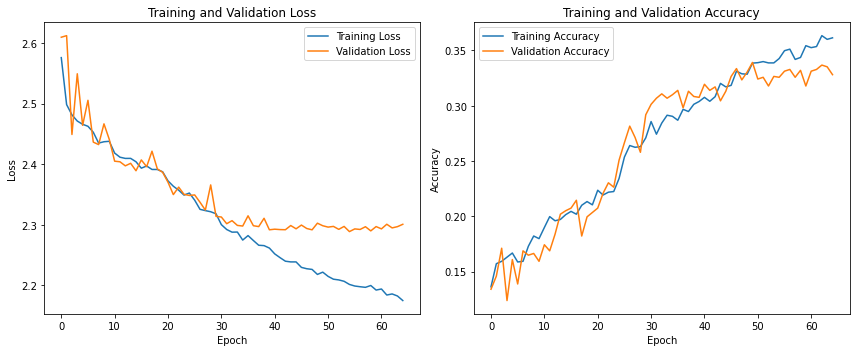

In [62]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainAcc, label='Training Accuracy')
plt.plot(valAcc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
# Save the model
torch.save(model.state_dict(), Path('../prototypes/FCModel.pth'))

In [46]:
# Run with transfer learning

# Load the model
model = torchvision.models.resnet50(torchvision.models.ResNet50_Weights.DEFAULT)

C:\Users\Peblo\AppData\Roaming\Python\Python310\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


In [47]:
model.fc = nn.Sequential(
    nn.Linear(2048, 256),
    nn.ReLU(),
    nn.Linear(256, NUM_CLASES),
    nn.Sigmoid(),
)

for param in model.fc.parameters():
    param.requires_grad = True

for param in model.layer4.parameters():
    param.requires_grad = True

In [48]:
model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [49]:
lossFunc = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters())
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)

trainLosses = []
trainAcc = []
valLosses = []
valAcc = []

bestLoss = float('inf')
bestModelWeights = None
patience = 10

def getBatchAccuracy(output, y):
    pred = output.argmax(dim=1, keepdim=True)
    correct = pred.eq(y.view_as(pred)).sum().item()
    return correct / len(y)

def validate():
    valLoss = 0
    correct = 0
    model.eval()

    with torch.no_grad():
        for x, y in valLoader:
            x, y = x.to(device), y.to(device)
            output = model(x)

            valLoss += lossFunc(output, y).item() * x.size(0)
            correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = valLoss / valSize
    accuracy = correct / valSize

    valLosses.append(avgLoss)
    valAcc.append(accuracy)

    print(f'(val) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

    global bestLoss, bestModelWeights, patience

    if valLoss < bestLoss:
        bestLoss = valLoss
        bestModelWeights = copy.deepcopy(model.state_dict())
        patience = 10

    else:
        patience -= 1
        if patience == 0:
            return True
        
    return False

def train():
    trainLoss = 0
    correct = 0
    model.train()
    
    for x, y in trainLoader:
        x, y = x.to(device), y.to(device)
        output = model(x)
        optimizer.zero_grad()
        batchLoss = lossFunc(output, y)
        batchLoss.backward()
        optimizer.step()

        trainLoss += batchLoss.item() * x.size(0)
        correct += getBatchAccuracy(output, y) * x.size(0)

    avgLoss = trainLoss / trainSize
    accuracy = correct / trainSize

    trainLosses.append(avgLoss)
    trainAcc.append(accuracy)

    print(f'(train) Loss: {avgLoss:.4f} Accuracy: {accuracy:.4f}')

In [50]:
epochs = 30

# Train the model
for epoch in range(epochs):
    print(f'Epoch {epoch}')
    train()
    if validate(): 
        break # Early stopping
    
    scheduler.step()

Epoch 0
(train) Loss: 2.1890 Accuracy: 0.5122
(val) Loss: 2.2189 Accuracy: 0.4361
Epoch 1
(train) Loss: 2.1017 Accuracy: 0.5706
(val) Loss: 2.2165 Accuracy: 0.4937
Epoch 2
(train) Loss: 2.0426 Accuracy: 0.6447
(val) Loss: 2.1989 Accuracy: 0.5284
Epoch 3
(train) Loss: 2.0247 Accuracy: 0.6820
(val) Loss: 2.0720 Accuracy: 0.6246
Epoch 4
(train) Loss: 1.9959 Accuracy: 0.7315
(val) Loss: 2.0892 Accuracy: 0.5647
Epoch 5
(train) Loss: 1.9859 Accuracy: 0.7350
(val) Loss: 2.0589 Accuracy: 0.6412
Epoch 6
(train) Loss: 1.9676 Accuracy: 0.7624
(val) Loss: 2.0239 Accuracy: 0.7058
Epoch 7
(train) Loss: 1.9507 Accuracy: 0.7888
(val) Loss: 1.9968 Accuracy: 0.7326
Epoch 8
(train) Loss: 1.9362 Accuracy: 0.8133
(val) Loss: 2.0219 Accuracy: 0.7216
Epoch 9
(train) Loss: 1.9203 Accuracy: 0.8344
(val) Loss: 1.9581 Accuracy: 0.8005
Epoch 10
(train) Loss: 1.8836 Accuracy: 0.8985
(val) Loss: 1.9319 Accuracy: 0.8360
Epoch 11
(train) Loss: 1.8577 Accuracy: 0.9340
(val) Loss: 1.9380 Accuracy: 0.8336
Epoch 12
(trai

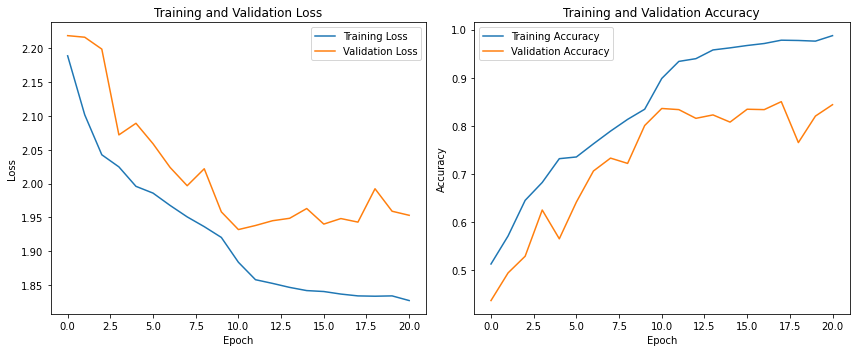

In [51]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(trainLosses, label='Training Loss')
plt.plot(valLosses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(trainAcc, label='Training Accuracy')
plt.plot(valAcc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

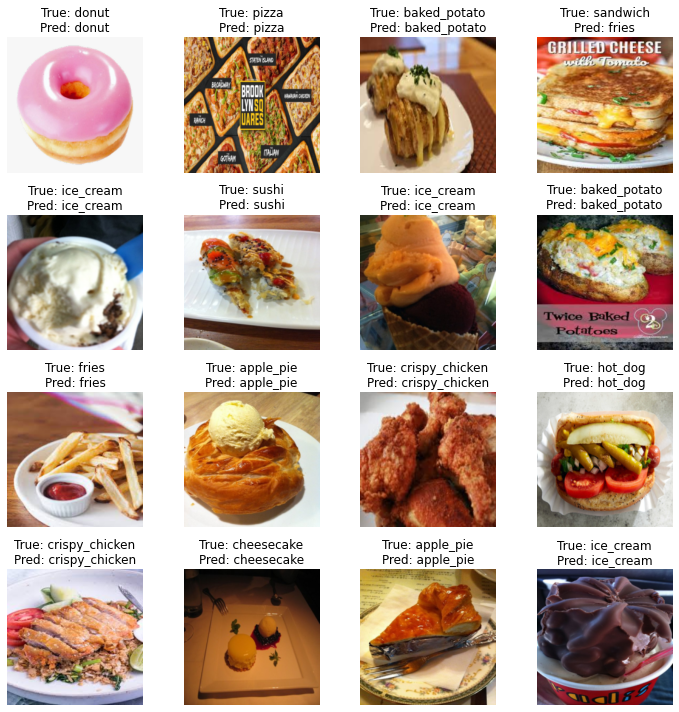

In [53]:
# Print the model predictions
model.eval()
images, labels = next(iter(valLoader))

images = images.to(device)
labels = labels.to(device)

with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

images = images.cpu().numpy()
labels = labels.cpu().numpy()
preds = preds.cpu().numpy()

fig, axes = plt.subplots(4, 4, figsize=(10, 10))
axes = axes.flatten()

for ax, img, label, pred in zip(axes, images, labels, preds):
    img = (img.transpose(1, 2, 0) + 1) / 2
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'True: {CLASSES[label]}\nPred: {CLASSES[pred]}')

plt.tight_layout()
plt.show()